In [39]:
# Import necessary libraries for image manipulation
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array  

# Import libraries for data handling and visualization
import os
import pandas as pd  
import matplotlib.pyplot as plt

# Import libraries for deep learning (TensorFlow and Keras)
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import layers  

# Import libraries for model interpretation
from tf_explain.core.grad_cam import GradCAM  
import lime  
from lime import lime_image  # LIME specifically for explaining image classification models  
from skimage.segmentation import mark_boundaries  


## 1) The Dataset

- Assuming you have a classification problem, is it binary, multi-class or multi-label?

> #### Binary classification problem 

- How many classes?

> #### 2 classes: adult or child
>
- Show a few examples per class

In [40]:
# Loading the csv file with all the image names and labels

df = pd.read_csv("complete_image.csv")

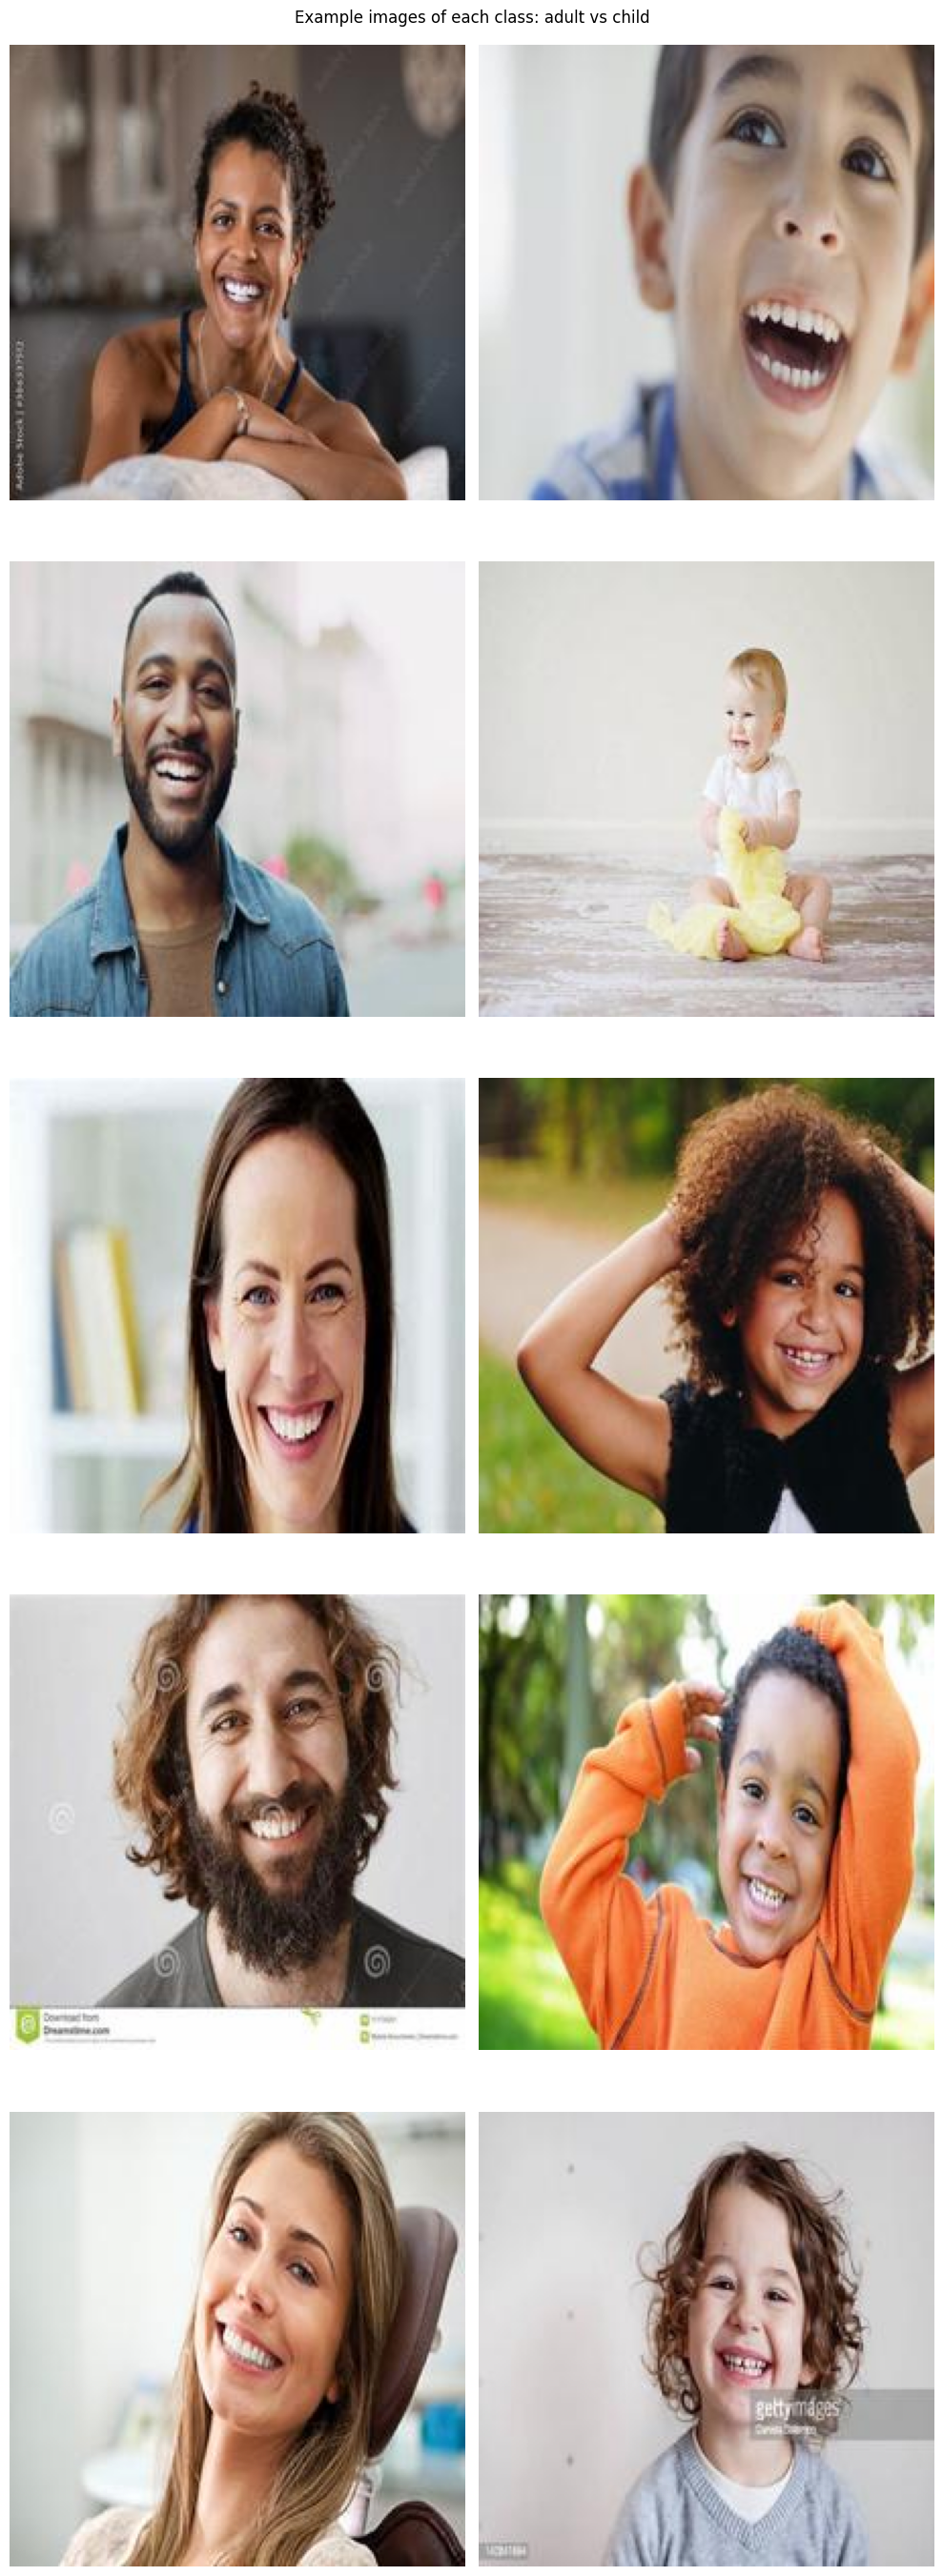

In [41]:
# Define directories for adult and child images
adult_dir = 'C:/Users/franc/OneDrive/Ambiente de Trabalho/Block C/User-case 3 - Correct dataset/data/train/adult'
child_dir = 'C:/Users/franc/OneDrive/Ambiente de Trabalho/Block C/User-case 3 - Correct dataset/data/train/child'

# Get the first 5 images from each directory
adult_images = os.listdir(adult_dir)[:5]
child_images = os.listdir(child_dir)[:5]

# Create a plot with 5 rows and 2 columns to display the images 
fig, axs = plt.subplots(5, 2, figsize=(10, 28))

# Adjust the top margin of the plot to create more space for the title
fig.subplots_adjust(top=1.15)
fig.suptitle('Example images of each class: adult vs child')

# Set the spacing between subplots to prevent overlapping
plt.subplots_adjust(hspace=1, wspace=0.75)

# Loop through each image and display it in the plot
for i in range(5):
    # Load the current adult image 
    adult_img = cv2.imread(os.path.join(adult_dir, adult_images[i]))
    adult_img = cv2.cvtColor(adult_img, cv2.COLOR_BGR2RGB)
        
    # Display the adult image in the left column of the current row
    axs[i, 0].imshow(adult_img)
    axs[i, 0].axis('off')
    
# Load the current child image
    child_img = cv2.imread(os.path.join(child_dir, child_images[i]))
    child_img = cv2.cvtColor(child_img, cv2.COLOR_BGR2RGB)
        
    # Display the child image in the right column of the current row
    axs[i, 1].imshow(child_img)
    axs[i, 1].axis('off')
    
# Adjust the layout of the plot and show it
plt.tight_layout()
plt.show()


In [42]:
# Displaying how the datframe looks
df.head(3)

file_name age_group
0  childsmiling465.jpeg     child
1  childsmiling350.jpeg     child
2        smiling_50.jpg     adult

- How many images per class?

In [43]:
print(f"There are {df['age_group'].str.count('adult').sum()} images of the 'adult' class")
print(f"\nThere are {df['age_group'].str.count('child').sum()} images of the 'child' class")

There are 522 images of the 'adult' class

There are 522 images of the 'child' class


- Train/Validation/Test sizes

In [44]:
print(f"Total of images in test folder: {len(os.listdir('data/test/child')) + len(os.listdir('data/test/adult'))}")
print(f"\nTotal of images in train folder: {len(os.listdir('data/train/child')) + len(os.listdir('data/train/adult'))}")
print(f"\nTotal of images in validation folder: {len(os.listdir('data/val/child')) + len(os.listdir('data/val/adult'))}")

Total of images in test folder: 209

Total of images in train folder: 668

Total of images in validation folder: 167


## 3) Preprocessing

All the pre-processing details can be found in greater detail in the following notebook: [Google-Image-Scraper](https://github.com/ohyicong/Google-Image-Scraper)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Setting the directory paths for the train, validation and test datasets
train_dir = 'data/train'
val_dir = 'data/val'
test_dir = 'data/test'

# Create an instance of the ImageDataGenerator class with data augmentation parameters
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# Load the images from the directory and apply data augmentation
train_generator = train_datagen.flow_from_directory(
        'data/train',
        classes=['child', 'adult'],
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary')

# Load the validation and test sets without data augmentation
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

val_generator = valid_datagen.flow_from_directory(
        'data/val',
        classes=['child', 'adult'],
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary')

test_generator = test_datagen.flow_from_directory(
        'data/test',
        classes=['child', 'adult'],
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary')


## 4) CNN architecture

In [46]:
# Import necessary packages
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16

# Creating a VGG16 model
base_model = VGG16(weights='imagenet',
                      include_top=False,
                      input_shape=(224, 224, 3))

# Creating a new model on top of the VGG16 model
model_vgg16 = Sequential()
model_vgg16.add(base_model)
# add one convolutional and max pooling layer here
model_vgg16.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model_vgg16.add(MaxPooling2D((2, 2)))
model_vgg16.add(Flatten())
model_vgg16.add(Dense(256, activation='relu'))
model_vgg16.add(Dropout(0.5))
model_vgg16.add(Dense(1, activation='sigmoid'))

# Freezing the VGG16 model
base_model.trainable = False



## 5) CNN training

- Loss function

- Optimizer (with its hyper-parameters)

- Metrics

- Learning curves (they have been done in different models)

In [47]:
from tensorflow.keras.callbacks import EarlyStopping

# Adding Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

In [48]:
from keras.optimizers import Adam

# Compiling the model
model_vgg16.compile(optimizer=Adam(lr=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])


c:\Users\franc\anaconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [49]:
# Training the model
H = model_vgg16.fit(
      train_generator,
      steps_per_epoch=len(train_generator),
      epochs=60,
      validation_data=val_generator, 
      validation_steps=len(val_generator),
      callbacks=[early_stopping],
      verbose=1)

Epoch 1/60
21/21 [==============================] - 7s 277ms/step - loss: 0.7318 - accuracy: 0.4955 - val_loss: 0.6866 - val_accuracy: 0.5210
Epoch 2/60
21/21 [==============================] - 7s 308ms/step - loss: 0.6818 - accuracy: 0.5569 - val_loss: 0.6648 - val_accuracy: 0.6587
Epoch 3/60
21/21 [==============================] - 7s 324ms/step - loss: 0.6693 - accuracy: 0.5898 - val_loss: 0.6476 - val_accuracy: 0.6407
Epoch 4/60
21/21 [==============================] - 8s 361ms/step - loss: 0.6642 - accuracy: 0.5988 - val_loss: 0.6316 - val_accuracy: 0.6707
Epoch 5/60
21/21 [==============================] - 8s 360ms/step - loss: 0.6472 - accuracy: 0.6272 - val_loss: 0.6101 - val_accuracy: 0.7425
Epoch 6/60
21/21 [==============================] - 8s 370ms/step - loss: 0.6217 - accuracy: 0.6587 - val_loss: 0.5854 - val_accuracy: 0.7186
Epoch 7/60
21/21 [==============================] - 8s 365ms/step - loss: 0.5913 - accuracy: 0.6931 - val_loss: 0.5500 - val_accuracy: 0.7725
Epoch 

## 6) Model performance

In [50]:
best_val_accuracy = max(H.history['val_accuracy'])
best_val_accuracy

0.8742514848709106

In [51]:
# Evaluating the model on the test set
test_loss, test_acc = model_vgg16.evaluate(test_generator, verbose=1)
print('Test accuracy:', test_acc)

7/7 [==============================] - 1s 82ms/step - loss: 0.4459 - accuracy: 0.7943
Test accuracy: 0.7942583560943604


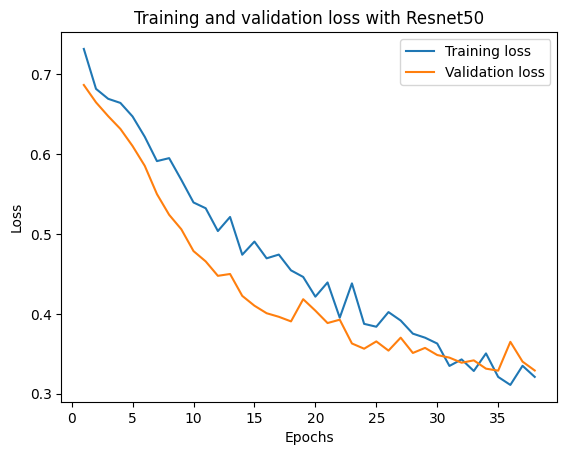

In [52]:
def loss_plotter(H):
    loss = H.history['loss']
    val_loss = H.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss')
    plt.title('Training and validation loss with Resnet50')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
 

loss_plotter(H)

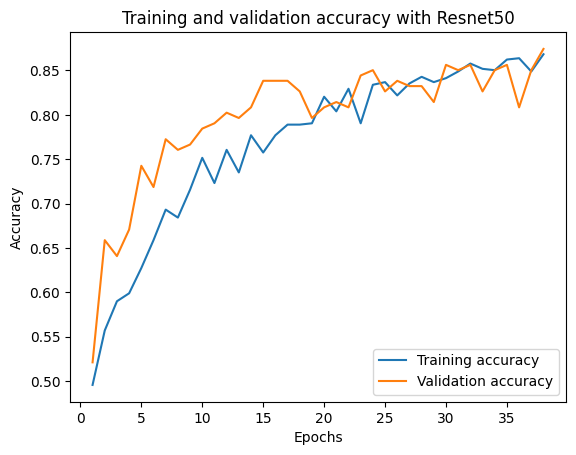

In [53]:
def accuracy_plotter(H):
    acc = H.history['accuracy']
    val_acc = H.history['val_accuracy']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, label='Training accuracy')
    plt.plot(epochs, val_acc, label='Validation accuracy')
    plt.title('Training and validation accuracy with Resnet50')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
accuracy_plotter(H)

## 7) Error analysis and explainable AI

21/21 [==============================] - 5s 260ms/step


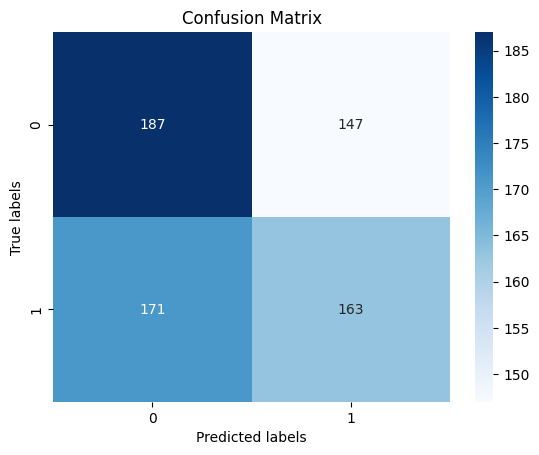

In [59]:
import seaborn as sns

# Generate predictions on the test dataset using the trained model
y_pred = model_vgg16.predict(train_generator)

# Convert the predicted probabilities to binary labels
y_pred_binary = np.round(y_pred)

# Calculate the confusion matrix to evaluate the performance of the model:
from sklearn.metrics import confusion_matrix

y_true = train_generator.classes
cm = confusion_matrix(y_true, y_pred_binary)

# Plot the confusion matrix using seaborn heatmap
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [61]:
class_indices = test_generator.class_indices
print(class_indices)

num_child_images = len(os.listdir(os.path.join(train_dir, 'child')))
num_adult_images = len(os.listdir(os.path.join(train_dir, 'adult')))
print('Number of child images:', num_child_images)
print('Number of adult images:', num_adult_images)

{'child': 0, 'adult': 1}
Number of child images: 334
Number of adult images: 334


- True positives (TP): The model correctly predicted 187 child images.
- False negatives (FN): The model incorrectly predicted 147 adult images as child images.
- False positives (FP): The model incorrectly predicted 171 child images as adult images.
- True negatives (TN): The model correctly predicted 163 adult images.


1/1 [==============================] - 0s 25ms/step


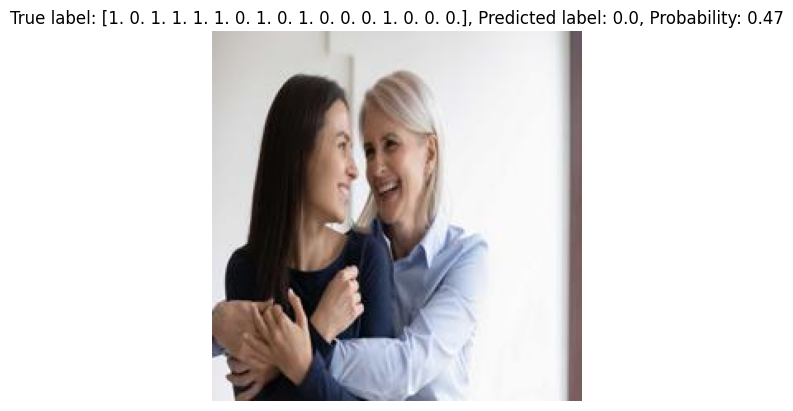

Misclassified probabilities:
[0.47357595]


In [68]:
# Get the predictions of the model on the test data 
y_pred = model_vgg16.predict(test_generator, steps=len(test_generator), verbose=1) 
y_true = test_generator.classes 

# Get the indices of the misclassified samples 
misclassified_indices = np.where(y_pred != y_true)[0] 
misclassified_indices_sample = np.random.choice(misclassified_indices, size=1, replace=False) 

# Generate and plot the misclassified samples 
misclassified_probabilities = [] 
for index in misclassified_indices_sample:
    index_wrapped = index % len(test_generator) 
    x, y_true = test_generator[index_wrapped] 
    y_pred_prob = model_vgg16.predict(x)[0][0] 
    y_pred = np.round(y_pred_prob) 
    misclassified_probabilities.append(y_pred_prob) 
    plt.imshow(x[0]) 
    plt.title(f"True label: {y_true}, Predicted label: {y_pred}, Probability: {y_pred_prob:.2f}") 
    plt.axis('off') 
    plt.show() 
    
# Print the misclassified probabilities 
print("Misclassified probabilities:") 
print(misclassified_probabilities)

7/7 [==============================] - 1s 121ms/step


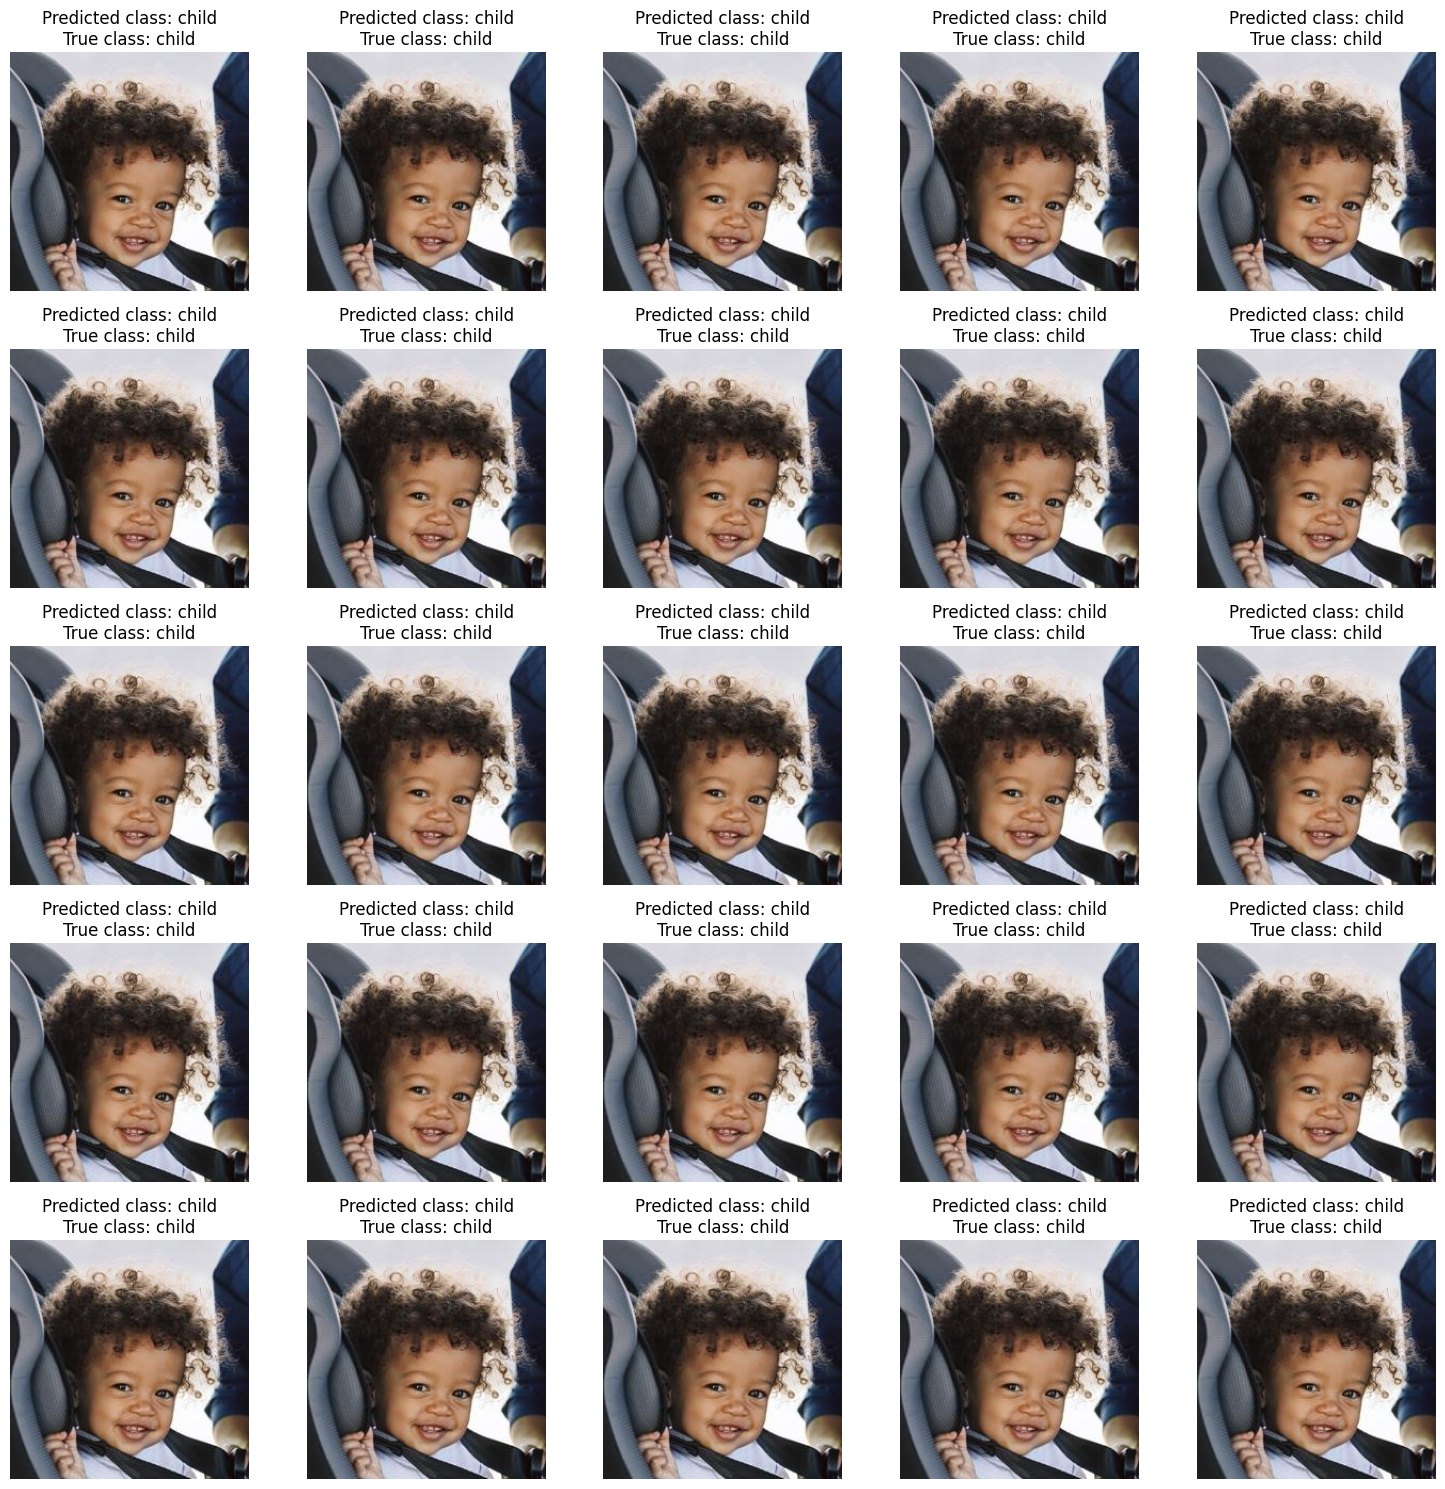

In [64]:
# Predicting on the test set
y_pred = model_vgg16.predict(test_generator)

# Getting the predicted classes
y_pred_classes = np.round(y_pred)

# Getting the true classes
y_true = test_generator.classes

# Getting the class names
class_names = list(test_generator.class_indices.keys())

# Getting the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Finding the indices of misclassified images
misclassified_indices = np.where(y_pred_classes != y_true)[0]

# Plotting the misclassified images
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(15,15))
for i, ax in enumerate(axes.flatten()):
    if i < len(misclassified_indices):
        img_index = misclassified_indices[i]
        img = test_generator[0][0][img_index]
        img_class = class_names[int(y_pred_classes[img_index])]
        true_class = class_names[int(y_true[img_index])]
        ax.imshow(img)
        ax.set_title(f"Predicted class: {img_class}\nTrue class: {true_class}")
        ax.axis("off")
    else:
        break
plt.tight_layout()
plt.show()

In [54]:
IMAGE_PATH = "data/test/child/childsmiling685.jpeg"
class_index = 0

img = tf.keras.preprocessing.image.load_img(IMAGE_PATH, target_size=(224, 224)) 
img = tf.keras.preprocessing.image.img_to_array(img) 

#model = tf.keras.applications.vgg16.VGG16(weights="imagenet", include_top=True) 

# get model summary 
model_vgg16.summary() 

#first create the input in a format that the explainer expects (a tuple) 
input_img = (np.array([img]), None) 

#initialize the explainer as an instance of the GradCAM object 
explainer = GradCAM() 

# Obtain explanations for your image using VGG 16 and GradCAM 
grid = explainer.explain(input_img, model_vgg16, class_index=0 ) 

# Save the resulting image 
explainer.save(grid, "./outputs/explain/", "grad_cam_occupied.png")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 5, 32)          147488    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 2, 2, 32)         0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               33024     
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                      

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 230ms/step


  1%|          | 10/1000 [00:00<00:39, 25.07it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 20/1000 [00:00<00:25, 37.75it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 30/1000 [00:00<00:22, 43.91it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▍         | 40/1000 [00:00<00:19, 48.32it/s]

1/1 [==============================] - 0s 32ms/step


  5%|▌         | 50/1000 [00:01<00:18, 52.12it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▌         | 60/1000 [00:01<00:16, 56.61it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 70/1000 [00:01<00:15, 59.97it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 80/1000 [00:01<00:14, 61.37it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 90/1000 [00:01<00:14, 62.51it/s]

1/1 [==============================] - 0s 28ms/step


 10%|█         | 100/1000 [00:01<00:13, 64.93it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█         | 110/1000 [00:01<00:13, 66.76it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 120/1000 [00:02<00:13, 66.58it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 130/1000 [00:02<00:13, 65.46it/s]

1/1 [==============================] - 0s 32ms/step


 14%|█▍        | 140/1000 [00:02<00:13, 65.86it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▌        | 150/1000 [00:02<00:12, 67.23it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 160/1000 [00:02<00:12, 69.25it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 170/1000 [00:02<00:12, 68.12it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 180/1000 [00:03<00:11, 68.42it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 190/1000 [00:03<00:11, 70.16it/s]

1/1 [==============================] - 0s 26ms/step


 20%|██        | 200/1000 [00:03<00:11, 71.65it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 210/1000 [00:03<00:10, 71.98it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 220/1000 [00:03<00:10, 71.04it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 230/1000 [00:03<00:10, 71.59it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 240/1000 [00:03<00:10, 73.44it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 250/1000 [00:03<00:10, 71.45it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 260/1000 [00:04<00:10, 71.78it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 270/1000 [00:04<00:10, 70.37it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 280/1000 [00:04<00:10, 69.57it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 290/1000 [00:04<00:10, 69.34it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███       | 300/1000 [00:04<00:09, 70.22it/s]

1/1 [==============================] - 0s 33ms/step


 31%|███       | 310/1000 [00:04<00:09, 69.10it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 320/1000 [00:04<00:09, 69.83it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 330/1000 [00:05<00:09, 71.52it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 340/1000 [00:05<00:09, 72.86it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▌      | 350/1000 [00:05<00:09, 71.74it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 360/1000 [00:05<00:09, 70.20it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 370/1000 [00:05<00:09, 68.37it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 380/1000 [00:05<00:09, 68.43it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 390/1000 [00:05<00:08, 68.51it/s]

1/1 [==============================] - 0s 32ms/step


 40%|████      | 400/1000 [00:06<00:08, 67.72it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████      | 410/1000 [00:06<00:09, 64.76it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 420/1000 [00:06<00:08, 64.67it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 430/1000 [00:06<00:08, 64.69it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 440/1000 [00:06<00:08, 65.12it/s]

1/1 [==============================] - 0s 33ms/step


 45%|████▌     | 450/1000 [00:06<00:08, 64.86it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 460/1000 [00:07<00:08, 66.54it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 470/1000 [00:07<00:08, 64.68it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 480/1000 [00:07<00:07, 65.19it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▉     | 490/1000 [00:07<00:07, 66.37it/s]

1/1 [==============================] - 0s 28ms/step


 50%|█████     | 500/1000 [00:07<00:07, 66.77it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████     | 510/1000 [00:07<00:07, 66.97it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 520/1000 [00:07<00:07, 64.80it/s]

1/1 [==============================] - 0s 32ms/step


 53%|█████▎    | 530/1000 [00:08<00:07, 66.16it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▍    | 540/1000 [00:08<00:06, 65.94it/s]

1/1 [==============================] - 0s 42ms/step


 55%|█████▌    | 550/1000 [00:08<00:07, 62.71it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▌    | 560/1000 [00:08<00:07, 62.70it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 570/1000 [00:08<00:06, 65.38it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 580/1000 [00:08<00:06, 66.16it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 590/1000 [00:09<00:06, 66.67it/s]

1/1 [==============================] - 0s 30ms/step


 60%|██████    | 600/1000 [00:09<00:05, 67.84it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 610/1000 [00:09<00:05, 69.58it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 620/1000 [00:09<00:05, 70.18it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 630/1000 [00:09<00:05, 68.44it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 640/1000 [00:09<00:05, 68.29it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▌   | 650/1000 [00:09<00:05, 66.79it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▌   | 660/1000 [00:10<00:05, 66.39it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 670/1000 [00:10<00:04, 68.45it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 680/1000 [00:10<00:04, 68.55it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▉   | 690/1000 [00:10<00:04, 66.30it/s]

1/1 [==============================] - 0s 29ms/step


 70%|███████   | 700/1000 [00:10<00:04, 66.52it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████   | 710/1000 [00:10<00:04, 67.66it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 720/1000 [00:10<00:04, 68.89it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 730/1000 [00:11<00:03, 70.03it/s]

1/1 [==============================] - 0s 33ms/step


 74%|███████▍  | 740/1000 [00:11<00:03, 70.59it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▌  | 750/1000 [00:11<00:03, 70.02it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▌  | 760/1000 [00:11<00:03, 67.80it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 770/1000 [00:11<00:03, 68.09it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 780/1000 [00:11<00:03, 67.34it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▉  | 790/1000 [00:11<00:03, 66.67it/s]

1/1 [==============================] - 0s 30ms/step


 80%|████████  | 800/1000 [00:12<00:02, 68.59it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████  | 810/1000 [00:12<00:02, 69.60it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 820/1000 [00:12<00:02, 71.59it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 830/1000 [00:12<00:02, 71.40it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 840/1000 [00:12<00:02, 69.40it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▌ | 850/1000 [00:12<00:02, 68.63it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 860/1000 [00:12<00:02, 69.03it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 870/1000 [00:13<00:01, 70.00it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 880/1000 [00:13<00:01, 70.11it/s]

1/1 [==============================] - 0s 39ms/step


 89%|████████▉ | 890/1000 [00:13<00:01, 64.52it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 900/1000 [00:13<00:01, 63.42it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████ | 910/1000 [00:13<00:01, 61.61it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 920/1000 [00:13<00:01, 64.17it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 930/1000 [00:14<00:01, 66.74it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▍| 940/1000 [00:14<00:00, 68.63it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▌| 950/1000 [00:14<00:00, 67.29it/s]

1/1 [==============================] - 0s 33ms/step


 96%|█████████▌| 960/1000 [00:14<00:00, 67.22it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 970/1000 [00:14<00:00, 68.10it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 980/1000 [00:14<00:00, 69.50it/s]

1/1 [==============================] - 0s 36ms/step


 99%|█████████▉| 990/1000 [00:14<00:00, 67.11it/s]

1/1 [==============================] - 0s 35ms/step


100%|██████████| 1000/1000 [00:15<00:00, 66.31it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


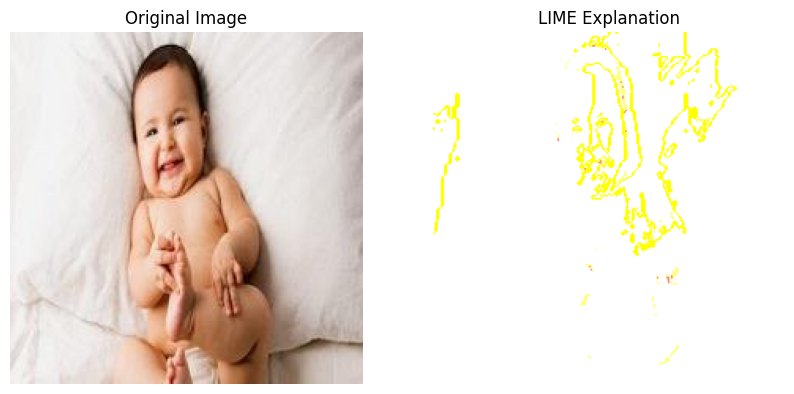

In [55]:
explainer = lime_image.LimeImageExplainer()

# Define a function that takes an input image and returns the predicted class probabilities
def predict_fn(images):
    return model_vgg16.predict(images)

# Load an image
IMAGE_PATH = "data/test/child/childsmiling685.jpeg"
original_image = load_img(IMAGE_PATH, target_size=(224, 224))
original_image_array = img_to_array(original_image)

# Generate an explanation using LIME
explanation = explainer.explain_instance(original_image_array, predict_fn, top_labels=5, hide_color=0, num_samples=1000)

# Visualize the explanation
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].imshow(original_image)
ax[0].set_title('Original Image')
ax[0].axis('off')

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
ax[1].imshow(mark_boundaries(temp / 2 + 0.5, mask))
ax[1].set_title('LIME Explanation')
ax[1].axis('off')

plt.show()